In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/Epilepsy/epilepsy_training.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

In [3]:
from epilepsy_utils import Tagger
from snorkel.parser import SentenceParser

dg_tagger = Tagger()
sent_parser = SentenceParser(fn=dg_tagger.tag)

[========================================] 100%%

Number of documents: 2500
CPU times: user 44.7 s, sys: 756 ms, total: 45.4 s
Wall time: 7min 38s


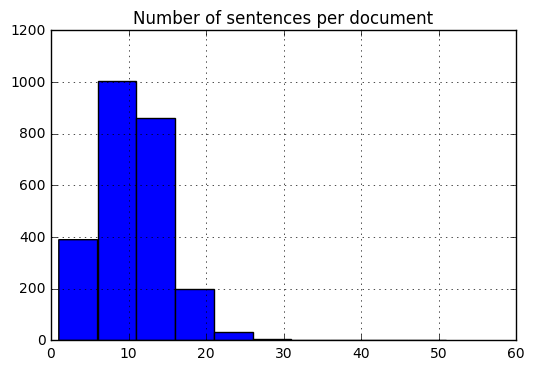

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, sent_parser, max_docs=5000)
%time corpus = cp.parse_corpus(name='Epilepsy Train', session=session)

In [5]:
session.add(corpus)
session.commit()

In [8]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/Epilepsy/epilepsy_testing.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

[========================================] 100%%

Number of documents: 1000
CPU times: user 17.1 s, sys: 296 ms, total: 17.4 s
Wall time: 2min 56s


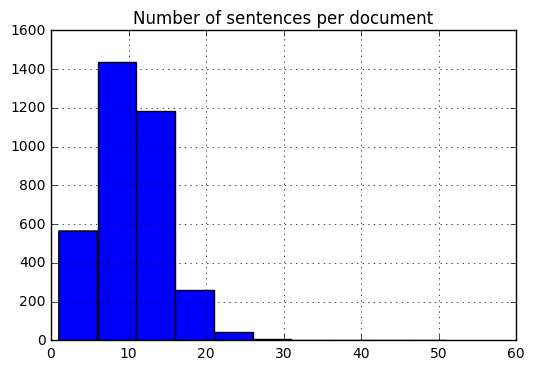

In [10]:
from snorkel.parser import CorpusParser
session.rollback()
cp = CorpusParser(xml_parser, sent_parser, max_docs=5000)
%time corpus = cp.parse_corpus(name='Epilepsy Test', session=session)

In [11]:
session.add(corpus)
session.commit()

In [12]:
from snorkel.models import candidate_subclass

DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [13]:
from snorkel.candidates import PretaggedCandidateExtractor

ce = PretaggedCandidateExtractor(DiseaseGene, ['Disease', 'Gene'])

In [14]:
from snorkel.models import Corpus
for corpus_name in ["Epilepsy Train","Epilepsy Test"]:
    corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
    sentences = set()
    for document in corpus:
        for sentence in document.sentences:
            sentences.add(sentence)
    %time c = ce.extract(sentences, corpus_name +" Candidates",session)
    print '{0} has {1} candidates'.format(corpus_name, len(c))
    session.add(c)
session.commit()

[========================================] 100%

CPU times: user 58.1 s, sys: 236 ms, total: 58.3 s
Wall time: 58.9 s
Epilepsy Train has 7376 candidates
[========================================] 100%

CPU times: user 22.1 s, sys: 68 ms, total: 22.1 s
Wall time: 22.7 s
Epilepsy Test has 2548 candidates


In [15]:
from snorkel.models import CandidateSet
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()
train = session.query(CandidateSet).filter(CandidateSet.name == 'Epilepsy Train Candidates').one()
test = session.query(CandidateSet).filter(CandidateSet.name == 'Epilepsy Test Candidates').one()

In [ ]:
#Check out the list of candidates and manually annotate the candidates
#from snorkel.viewer import SentenceNgramViewer

#view = SentenceNgramViewer(train,session)
#view

In [19]:
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_test = feature_manager.update(session,test,'Train Features',False)

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 11min 18s, sys: 1.69 s, total: 11min 19s
Wall time: 11min 21s
[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 3min 55s, sys: 852 ms, total: 3min 56s
Wall time: 3min 57s


In [20]:
import re
from snorkel.lf_helpers import (
    get_left_tokens,
    get_right_tokens, 
    get_between_tokens,
    get_tagged_text,
    get_text_between,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

In [21]:
#insert label functions here!!!
#For my hackish debugger purposes only
def LF_debugger(c):
    print c
    print
    print vars(c)
    print
    print vars(c[0])
    print
    print c[0]
    print 
    print c[0].get_span()
    print
    print get_tagged_text(c)
    print
    print get_text_between(c)
    print
    print get_between_tokens(c)
    print
    print get_left_tokens(c)
    print
    print get_right_tokens(c)
    print
    sys.exit(1)
    return 1 if c else 0

def LF_between_tag(c):
    m = re.search("associated with|Disruption",get_text_between(c))
    return 1 if m else 0

def LF_mutation(c):
    m = re.search("mutation", ",".join(get_left_tokens(c)))
    n = re.search("mutation", ",".join(get_right_tokens(c)))
    return 1 if m or n else 0

def LF_check_disease_tag(c):
    disease_name = c[0].get_span()
    if "syndrome" in disease_name:
        if "epilepsy" in disease_name.replace("syndrome",""):
            return 1
        else:
            return -1
    else:
        return 1 if "epilepsy" in disease_name else 0

In [22]:
LFs = [
    #LF_debugger
    LF_between_tag,
    LF_mutation,
    LF_check_disease_tag,
]

In [23]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

In [24]:
%time L_train = label_manager.create(session, train, 'LF Train Labels', f=LFs)
%time L_test = label_manager.create(session, test, 'LF Test Labels', f=LFs)
L_train
L_test

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 32.4 s, sys: 68 ms, total: 32.5 s
Wall time: 32.8 s
[========================================] 100%

Loading sparse Label matrix...
CPU times: user 11.3 s, sys: 68 ms, total: 11.4 s
Wall time: 11.5 s


<2548x3 sparse matrix of type '<type 'numpy.float64'>'
	with 1301 stored elements in Compressed Sparse Row format>

In [25]:
L_train.lf_stats()
L_test.lf_stats()

,j,coverage,overlaps,conflicts
LF_between_tag,0,0.104788,0.036107,0.010989
LF_mutation,1,0.148744,0.052983,0.027865
LF_check_disease_tag,2,0.257064,0.070251,0.037677


In [26]:
#Train the model
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train)
train_marginals = gen_model.marginals(L_train)

/home/davidnicholson/anaconda3/envs/snorkeling/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	7376
Features:			3
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.028778
	Learning epoch = 250	Gradient mag. = 0.028347
	Learning epoch = 500	Gradient mag. = 0.026948
	Learning epoch = 750	Gradient mag. = 0.025977
Final gradient magnitude for rate=0.01, mu=1e-06: 0.025


In [29]:
train_marginals

array([ 0.5       ,  0.5       ,  0.5       , ...,  0.32396321,
        0.32396321,  0.32396321])

In [35]:
from snorkel.annotations import FeatureManager
feature_manager = FeatureManager()
%time F_train = feature_manager.load(session, train, 'Train Features')
%time F_test = feature_manager.load(session,test,'Train Features')

CPU times: user 6.21 s, sys: 48 ms, total: 6.26 s
Wall time: 6.24 s
[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 2min 28s, sys: 452 ms, total: 2min 28s
Wall time: 2min 29s


In [36]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=5000, rate=1e-3)

Training marginals (!= 0.5):	3022
Features:			103780
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 2094.690780	Gradient magnitude = 709.661750
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 1820.403300	Gradient magnitude = 58.384926
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 1808.769871	Gradient magnitude = 8.763705
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 1804.478272	Gradient magnitude = 6.403146
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 1802.225522	Gradient magnitude = 5.127766
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 1800.859906	Gradient magnitude = 4.331352
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 1799.956538	Gradient magnitude = 3.790521
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 1799.322196	Gradient magnitude = 3.402592
	Learning epoch = 800	Step size = 0.00044914914861
	Loss = 1798.857356	Gradient magnitude = 3.113730
	Learning epoch

Scores (Un-adjusted)
Pos. class accuracy: 0.978
Neg. class accuracy: 0.329
Precision            0.146
Recall               0.978
F1                   0.254
----------------------------------------
TP: 261 | FP: 1530 | TN: 751 | FN: 6


Calibration plot:


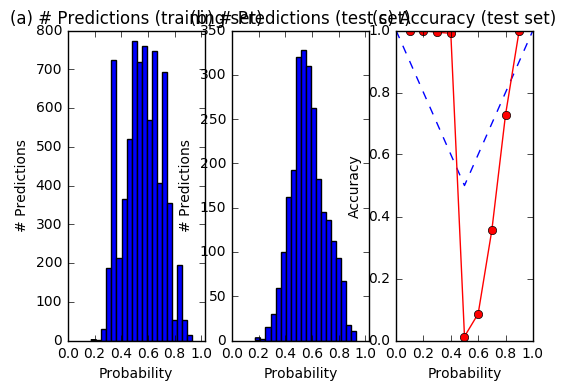

4

In [40]:
# This is cool.
# The output for the score function will give me the candiates and their corresponding categories:
# TP, FP, TN, FN
output = disc_model.score(F_test,L_test)

In [75]:
# For each candidate output the given prediction
# Now this will work!!!
print F_test.get_candidate(1)[0].parent
#print F_test.get_candidate(1).context.id
print F_test.get_candidate(1)
#disc_model.predict(F_test)
import inspect
vars(list(output[0])[0][0].parent)

Sentence(Document 23684790, 1, u'An intriguing finding about the gene encoding methyl-CpG binding protein 2 (MeCP2) is that the loss-of-function mutations cause Rett syndrome and duplication (gain-of-function) of MECP2 leads to another neurological disorder termed MECP2 duplication syndrome.')
DiseaseGene(Span("gain-of-function", parent=28415, chars=[159,174], words=[25,25]), Span("methyl-CpG binding protein 2", parent=28415, chars=[46,73], words=[7,10]))


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f72398aab10>,
 'char_offsets': [0,
  3,
  11,
  13,
  17,
  28,
  31,
  37,
  40,
  49,
  54,
  66,
  74,
  79,
  83,
  89,
  92,
  97,
  106,
  112,
  115,
  123,
  134,
  138,
  144,
  148,
  157,
  159,
  171,
  177,
  181,
  185,
  194,
  203,
  204,
  213,
  217,
  223,
  236,
  238,
  249,
  254,
  260,
  266,
  275],
 'dep_labels': [u'case',
  u'ROOT',
  u'punct',
  u'det',
  u'root',
  u'case',
  u'nmod',
  u'case',
  u'amod',
  u'compound',
  u'compound',
  u'nmod',
  u'nsubjpass',
  u'auxpass',
  u'acl:relcl',
  u'mark',
  u'xcomp',
  u'amod',
  u'dobj',
  u'case',
  u'compound',
  u'nmod',
  u'cc',
  u'nsubj',
  u'advmod',
  u'conj',
  u'det',
  u'amod',
  u'dobj',
  u'case',
  u'det',
  u'amod',
  u'nmod',
  u'punct',
  u'dep',
  u'cc',
  u'conj',
  u'dep',
  u'punct',
  u'acl',
  u'case',
  u'amod',
  u'compound',
  u'nmod',
  u'punct'],
 'dep_parents': [2,
  0,
  2,
  5,
  3,
  7,
  5,
  12,
  12,
  12,
  12

In [68]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(output[0], session,output[0], annotator_name="Tutorial Part V 2User")
else:
    sv = None

AttributeError: 'DiseaseGene' object has no attribute 'context_id'

In [53]:
sv